## SECTION 3: Model Training – ML & Deep Learning

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
import scispacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
import warnings
import pickle
import string
import re
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
def read_data(path_to_csv_file, delimiter=None):
    '''
    Reads csv file from specified path
    '''
    df = pd.read_csv(path_to_csv_file, delimiter=delimiter)

    return df

# call function to import data  - UPDATE PATH HERE TO RUN MODEL
df_patient = read_data('/Users/mncedisimncwabe/Downloads/patient_behavior_data.csv', delimiter=";")
df_patient.head()

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15mg,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,NaN,NaN,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15mg,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,NaN,5mg,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30mg,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


In [4]:
# Replace "None" records with "Not Specified"
def replace_missing_with_none(df, column_names):
    '''
    Replace missing values in the specified columns with None.
    '''

    for column_name in column_names:
        if column_name in df.columns:
            df[column_name] = df[column_name].where(df[column_name].notna(), "Not Specified")
        else:
            raise ValueError(f"Column '{column_name}' not found in DataFrame.")
    return df

patient_df_cleaned = replace_missing_with_none(df_patient, ['medication'])
patient_df_cleaned.head()

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15mg,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,Not Specified,NaN,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15mg,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,Not Specified,5mg,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30mg,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


In [5]:
# Now extract the numerical value from dose and fill the missing values with median. eg 15mg will be 15
def clean_and_fill_dose(df, dose_column='dose'):
    def extract_dose_value(dose):
        if pd.isna(dose):
            return None
        return float(dose.rstrip('mg'))

    df['dose'] = df[dose_column].apply(extract_dose_value)

    # fill in missing dose values with median
    median_dose = df['dose'].median()
    df['dose'].fillna(median_dose, inplace=True)

    return df

patient_df_cleaned = clean_and_fill_dose(patient_df_cleaned)
patient_df_cleaned.head()

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,Not Specified,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,Not Specified,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


In [6]:
def clean_clinical_notes(text):
    """
    Keep only the first coherent sentence from doctor notes.
    Removes all text after the first period followed by space and capital letter.
    """
    if pd.isna(text):
        return ""

    # Find the first sentence-ending period followed by space and capital letter
    match = re.search(r'\.\s+[A-Z]', str(text))

    if match:
        return text[:match.start()+1].strip()
    else:
        return str(text).strip()

patient_df_cleaned['doctor_notes'] = patient_df_cleaned['doctor_notes'].apply(clean_clinical_notes)
patient_df_cleaned.head()

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects.
1,2,Other,Not Specified,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed.
2,3,Male,Vyvanse,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up.
3,4,Female,Not Specified,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite.


In [7]:
# Load spaCy's English model
nlp_spacy = spacy.load('en_core_web_sm')

# Keep some custom medical terms stopwords
MEDICAL_STOPWORDS = {'patient', 'history', 'normal', 'exam', 'physical', 'day', 'week', 'month', 'year', 'status', 'note', 'findings'}
STOP_WORDS.update(MEDICAL_STOPWORDS)

def remove_emojis_special_chars(text):
    """Remove emojis and special characters from text"""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002500-\U00002BEF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"
                           u"\u3030"
                           "]+", flags=re.UNICODE)

    text = re.sub(r'[^\w\s.,!?]', '', text)
    return emoji_pattern.sub(r'', text)

def preprocess_text(text):
    """
    Preprocess clinical notes by:
    1. Removing emojis/special characters
    2. Tokenizing
    3. Lemmatizing
    4. Removing stopwords (while preserving medical terms)
    """
    if pd.isna(text):
        return ""

    # lower case text
    cleaned_text = remove_emojis_special_chars(str(text).lower())

    # tokenization
    doc = nlp_spacy(cleaned_text)

    processed_tokens = []
    for token in doc:
        if (not token.is_punct and
            not token.is_space and
            (not token.is_stop or token.text in MEDICAL_STOPWORDS)):

            # lemmatization
            lemma = token.lemma_.strip().lower()
            if lemma:
                processed_tokens.append(lemma)

    return " ".join(processed_tokens)

patient_df_processed = patient_df_cleaned.copy()
patient_df_processed['processed_notes'] = patient_df_processed['doctor_notes'].apply(preprocess_text)
patient_df_processed.head()

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes,processed_notes
0,1,Other,Adderall,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects.,need review medication effect
1,2,Other,Not Specified,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed.,significant behavioral change observe
2,3,Male,Vyvanse,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up.,mood swing note followup
3,4,Female,Not Specified,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...,increase talkativeness interrupt behavior
4,5,Female,Vyvanse,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite.,significant improvement appetite


#### 1. Prepare features: encode categorical and normalise numeric.

In [8]:
# perfome one-hot encoding on gender and medicaiton
def one_hot_encode_columns(df, columns_to_encode):
    df_encoded = df.copy()
    df_encoded = pd.get_dummies(df_encoded, columns=columns_to_encode)
    for col in df_encoded.columns:
        if df_encoded[col].dtype == 'bool':
            df_encoded[col] = df_encoded[col].astype(int)

    return df_encoded

columns_to_encode = ['gender', 'medication']
encoded_df = one_hot_encode_columns(patient_df_processed, columns_to_encode)
encoded_df.head()

,patient_id,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes,processed_notes,gender_Female,gender_Male,gender_Other,medication_Adderall,medication_Concerta,medication_Not Specified,medication_Ritalin,medication_Strattera,medication_Vyvanse
0,1,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects.,need review medication effect,0,0,1,1,0,0,0,0,0
1,2,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed.,significant behavioral change observe,0,0,1,0,0,1,0,0,0
2,3,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up.,mood swing note followup,0,1,0,0,0,0,0,0,1
3,4,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...,increase talkativeness interrupt behavior,1,0,0,0,0,1,0,0,0
4,5,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite.,significant improvement appetite,1,0,0,0,0,0,0,0,1


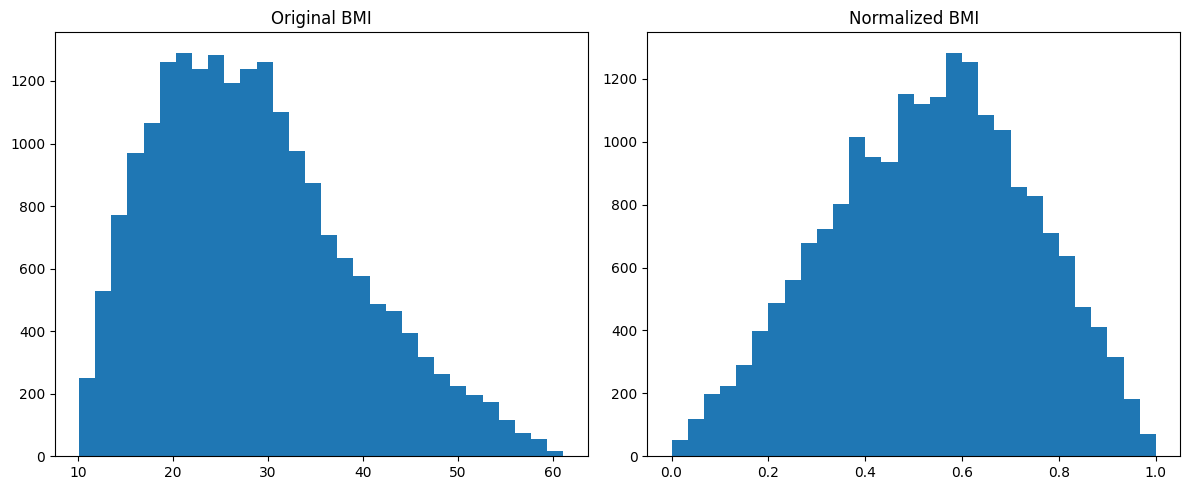

,patient_id,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes,processed_notes,gender_Female,gender_Male,gender_Other,medication_Adderall,medication_Concerta,medication_Not Specified,medication_Ritalin,medication_Strattera,medication_Vyvanse,bmi_normalized,weight_normalized,height_normalized,systolic_normalized,diastolic_normalized,dose_normalized
0,1,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects.,need review medication effect,0,0,1,1,0,0,0,0,0,0.533215,0.134035,0.345445,-0.137637,1.460735,0.597255
1,2,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed.,significant behavioral change observe,0,0,1,0,0,1,0,0,0,0.290368,-1.189886,0.229837,1.418999,-0.331275,0.597255
2,3,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up.,mood swing note followup,0,1,0,0,0,0,0,0,1,0.691350,1.518527,0.576660,0.877560,0.228728,0.597255
3,4,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...,increase talkativeness interrupt behavior,1,0,0,0,0,1,0,0,0,0.707048,0.493138,-0.695025,-0.949795,0.340729,0.000000
4,5,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite.,significant improvement appetite,1,0,0,0,0,0,0,0,1,0.302926,-1.704744,-1.099652,-0.272997,0.676730,1.000000


In [9]:
def normalize_features(df, numerical_features):
    """
    Apply appropriate normalization technique to each feature.
    """
    # Create a copy of the dataframe to avoid modifying the original
    normalized_df = df.copy()

    # Initialize scalers
    std_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()

    # BMI - Log transform + MinMax scaling (right-skewed)
    normalized_df['bmi_normalized'] = df['bmi'].map(lambda x: np.log1p(x) if x > 0 else 0)
    normalized_df['bmi_normalized'] = minmax_scaler.fit_transform(normalized_df[['bmi_normalized']])

    # Weight - Standard scaling (uniform distribution)
    normalized_df['weight_normalized'] = std_scaler.fit_transform(df[['weight']])

    # Height - Standard scaling
    normalized_df['height_normalized'] = std_scaler.fit_transform(df[['height']])

    # Systolic BP - Standard scaling
    normalized_df['systolic_normalized'] = std_scaler.fit_transform(df[['systolic']])

    # Diastolic BP - Standard scaling
    normalized_df['diastolic_normalized'] = std_scaler.fit_transform(df[['diastolic']])

    # Dose - Log transform + MinMax scaling (right-skewed with multiple peaks)
    normalized_df['dose_normalized'] = df['dose'].map(lambda x: np.log1p(x) if x > 0 else 0)
    normalized_df['dose_normalized'] = minmax_scaler.fit_transform(normalized_df[['dose_normalized']])

    # view before and after normalization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(df['bmi'], bins=30)
    plt.title('Original BMI')
    plt.subplot(1, 2, 2)
    plt.hist(normalized_df['bmi_normalized'], bins=30)
    plt.title('Normalized BMI')
    plt.tight_layout()
    plt.show()

    return normalized_df

numerical_features = ['bmi', 'weight', 'height', 'systolic', 'diastolic', 'dose']
normalized_df = normalize_features(encoded_df, numerical_features)
normalized_df.head()

#### 2. Baseline: Predict concentration using Random Forest.

In [10]:
def set_features_and_target(df):
    '''
    Returns two data frames with features and target variables.
    '''
    X = df.drop(['patient_id','name','surname','dose','bmi','weight','height',
                  'systolic','diastolic','doctor_notes','processed_notes','concentration'], axis=1)
    y = df['concentration']

    return X,y

X,y = set_features_and_target(normalized_df)
print(X.shape, y.shape)

(19999, 21) (19999,)


In [11]:
def train_test_split_df(X,y):
    '''
    Creates train and test split.
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_df(X,y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(13999, 21) (13999,)
(6000, 21) (6000,)


In [12]:
def model_application(X_train,y_train,optimiser):
    '''
    Model application. If optimiser is true , a grid search is applied to optimise the model.
    '''
    if optimiser == True:
                params = {
                'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10],
                'min_samples_leaf': [1, 3, 10],
                'criterion': ["entropy", "gini"]
                }

                cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=15)

                # Building model
                rf = RandomForestClassifier()
                grid = GridSearchCV(rf, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)

                # Fitting the model
                grid.fit(X_train, y_train)

                dtc_grid_val_score = grid.best_score_
                print('Best Score:', dtc_grid_val_score)
                print('Best Params:', grid.best_params_)
                print('Best Estimator:', grid.best_estimator_)

                rf_model = grid.best_estimator_
    else:
                rf_model = RandomForestClassifier(n_estimators=100,
                                                    max_depth=5,
                                                    min_samples_split=10,
                                                    min_samples_leaf=8,
                                                    max_features='sqrt',
                                                    bootstrap=True,
                                                    oob_score=True,
                                                    class_weight='balanced',
                                                    random_state=42
                                                  )
                rf_model.fit(X_train, y_train)

    return rf_model

rf_model = model_application(X_train,y_train,optimiser=False)

In [13]:
def model_predict(X_test):
    '''
    Create y_pred , model prediction based on test set features.
    '''
    y_pred = rf_model.predict(X_test)

    return y_pred

y_pred = model_predict(X_test)
print('Training Accuracy Score(%):',rf_model.score(X_train,y_train)*100)
print('Test Accuracy Score(%):',rf_model.score(X_test,y_test)*100)

Training Accuracy Score(%): 33.88099149939281
Test Accuracy Score(%): 20.016666666666666


In [14]:
def generate_performance_metrics(y_test, y_pred, model_name=""):
    score = accuracy_score(y_test, y_pred)
    if model_name:
        print(f"\n=== {model_name} Performance ===")
    print('Model Accuracy:', score)
    print('Classification Report:\n', classification_report(y_test, y_pred, zero_division=0))

    return score

y_pred_rf = rf_model.predict(X_test)
generate_performance_metrics(y_test, y_pred_rf, "Random Forest")


=== Random Forest Performance ===
Model Accuracy: 0.20016666666666666
Classification Report:
               precision    recall  f1-score   support

          -2       0.20      0.21      0.20      1198
          -1       0.19      0.18      0.19      1205
           0       0.20      0.29      0.24      1199
           1       0.21      0.15      0.18      1188
           2       0.20      0.16      0.18      1210

    accuracy                           0.20      6000
   macro avg       0.20      0.20      0.20      6000
weighted avg       0.20      0.20      0.20      6000



0.20016666666666666

#### 3. LSTM: Predict impulsivity from doctor_notes.

In [23]:
def lstm_model(patient_df_processed):
    # Preprocess labels (-2 to 2) -> (0 to 4)
    X = patient_df_processed['processed_notes'].values
    y = patient_df_processed['impulsivity'].values + 2

    # Split data (stratified to maintain class balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Text tokenization with limited vocabulary
    tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    # Convert text to sequences and pad
    max_length = 30
    X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
    X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)

    # Model architecture
    model = Sequential([
        Embedding(1000, 16, input_length=max_length),
        LSTM(32, dropout=0.1),
        Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Training
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )

    # Training metrics
    print("\nTraining Accuracy per Epoch:")
    for epoch, acc in enumerate(history.history['accuracy'], 1):
        print(f"Epoch {epoch}: {acc:.4f}")

    # Evaluation
    print("\nEvaluating on test set...")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    # Predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_original = y_test - 2  # Convert back to original scale (-2 to 2)
    y_pred_original = y_pred_classes - 2

    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    mae = mean_absolute_error(y_test_original, y_pred_original)

    # Print metrics
    print("\n================= Metrics =================")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"MAE: {mae:.4f}")

    print("\n================ Classification Report ===============")
    print(classification_report(
        y_test_original, y_pred_original,
        target_names=['-2', '-1', '0', '1', '2']
    ))

    return model, tokenizer

model, tokenizer = lstm_model(patient_df_processed)

Training model...
Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.1981 - loss: 1.6099 - val_accuracy: 0.2121 - val_loss: 1.6094
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2036 - loss: 1.6091 - val_accuracy: 0.2129 - val_loss: 1.6089
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2237 - loss: 1.6082 - val_accuracy: 0.2104 - val_loss: 1.6091
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2192 - loss: 1.6076 - val_accuracy: 0.2075 - val_loss: 1.6098
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2225 - loss: 1.6075 - val_accuracy: 0.2086 - val_loss: 1.6101

Training Accuracy per Epoch:
Epoch 1: 0.1983
Epoch 2: 0.2034
Epoch 3: 0.2171
Epoch 4: 0.2142
Epoch 5: 0.2212

Evaluating on test set...

================= Metrics =================
Test Accuracy: 0.1953
Test Loss: 1.6127
F1 Score: 0.1800
Precision: 0.1932
Recall: 0.1953
MAE: 1.5305

================ Classification Report ===============
  

In [27]:
def clstm_model(patient_df_processed):
    # Separate features and target variable and encode variables
    X = patient_df_processed.drop(['impulsivity','doctor_notes','patient_id','name','surname'], axis=1)
    y = patient_df_processed['impulsivity']

    categorical_cols = ['gender', 'medication']
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    ordinal_cols = ['concentration', 'distractibility',  'hyperactivity', 'sleep', 'mood', 'appetite']
    ordinal_mapping = {-2: 0,-1: 1,0: 2, 1: 3, 2: 4}
    for col in ordinal_cols:
        X[col] = X[col].map(ordinal_mapping)

    # Scale numerical features
    numerical_cols = ['dose', 'bmi', 'weight', 'height', 'systolic', 'diastolic']
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    # Text processing
    text_col = 'processed_notes'
    max_words = 1000
    tokenizer = Tokenizer(num_words=max_words, oov_token="<oov>")
    tokenizer.fit_on_texts(X[text_col])
    sequences = tokenizer.texts_to_sequences(X[text_col])
    max_sequence_length = 200
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    y = to_categorical(y, num_classes=5)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Separate text and tabular data for the model
    X_train_text = padded_sequences[X_train.index]
    X_test_text = padded_sequences[X_test.index]

    X_train_tabular = X_train.drop(text_col, axis=1)
    X_test_tabular = X_test.drop(text_col, axis=1)

    # Model Architecture (CLSTM)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    embedding_layer = Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length)(text_input)
    conv1d_layer = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding_layer)
    maxpooling1d_layer = MaxPooling1D(pool_size=4)(conv1d_layer)
    lstm_layer = LSTM(units=128)(maxpooling1d_layer)
    dropout_text = Dropout(0.5)(lstm_layer)

    # Tabular input branch
    tabular_input = Input(shape=(X_train_tabular.shape[1],), name='tabular_input')
    dense_tabular = Dense(units=64, activation='relu')(tabular_input)
    dropout_tabular = Dropout(0.5)(dense_tabular)
    combined = Concatenate()([dropout_text, dropout_tabular])
    dense_combined = Dense(units=128, activation='relu')(combined)
    output = Dense(units=5, activation='softmax')(dense_combined)
    model = Model(inputs=[text_input, tabular_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())

    # Train the model
    # Convert tabular data to numpy arrays
    X_train_tabular_np = np.array(X_train_tabular).astype(np.float32)
    X_test_tabular_np = np.array(X_test_tabular).astype(np.float32)

    history = model.fit(
        [X_train_text, X_train_tabular_np],
        y_train,
        epochs=5,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )

    # Evaluate the model
    y_pred_train = model.predict([X_train_text, X_train_tabular_np])
    y_pred_test = model.predict([X_test_text, X_test_tabular_np])
    y_pred_train_classes = np.argmax(y_pred_train, axis=1)
    y_pred_test_classes = np.argmax(y_pred_test, axis=1)

    y_train_classes = np.argmax(y_train, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Convert back to original scale (-2 to 2)
    y_train_original = y_train_classes - 2
    y_test_original = y_test_classes - 2
    y_pred_train_original = y_pred_train_classes - 2
    y_pred_test_original = y_pred_test_classes - 2

    # Print training and testing accuracy
    train_accuracy = accuracy_score(y_train_original, y_pred_train_original)
    test_accuracy = accuracy_score(y_test_original, y_pred_test_original)
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")

    # Calculate additional metrics
    train_f1 = f1_score(y_train_original, y_pred_train_original, average='weighted')
    test_f1 = f1_score(y_test_original, y_pred_test_original, average='weighted')
    train_precision = precision_score(y_train_original, y_pred_train_original, average='weighted')
    test_precision = precision_score(y_test_original, y_pred_test_original, average='weighted')
    train_recall = recall_score(y_train_original, y_pred_train_original, average='weighted')
    test_recall = recall_score(y_test_original, y_pred_test_original, average='weighted')
    train_mae = mean_absolute_error(y_train_original, y_pred_train_original)
    test_mae = mean_absolute_error(y_test_original, y_pred_test_original)

    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Testing F1 Score: {test_f1:.4f}")
    print(f"Training Precision: {train_precision:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Training Recall: {train_recall:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")

    # Print classification report
    print("\nClassification Report - Training Data:")
    print(classification_report(
        y_train_original, y_pred_train_original,
        target_names=['-2', '-1', '0', '1', '2']
    ))
    print("\nClassification Report - Testing Data:")
    print(classification_report(
        y_test_original, y_pred_test_original,
        target_names=['-2', '-1', '0', '1', '2']
    ))

    return model, history, y_test_original, y_pred_test_original

model, history, y_test_original, y_pred_test_original = clstm_model(patient_df_processed)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 200, 128)  │    128,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 196, 64)   │     41,024 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 49, 64)    │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 128)       │     98,816 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │        960 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 192)       │          0 │ dropout_10[0][0], │
│ (Concatenate)       │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     24,704 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 5)         │        645 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 294,149 (1.12 MB)

 Trainable params: 294,149 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.1981 - loss: 1.6709 - val_accuracy: 0.1975 - val_loss: 1.6152
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 43s 206ms/step - accuracy: 0.2059 - loss: 1.6212 - val_accuracy: 0.1943 - val_loss: 1.6123
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.2018 - loss: 1.6154 - val_accuracy: 0.1968 - val_loss: 1.6119
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.2044 - loss: 1.6125 - val_accuracy: 0.1957 - val_loss: 1.6134
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.2107 - loss: 1.6083 - val_accuracy: 0.2111 - val_loss: 1.6116
438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step
Training Accuracy: 0.2221
Testing Accuracy: 0.2000
Training F1 Score: 0.1714
Testing F1 Score: 0.1513
Training Precision: 0.2334
Testing Precision: 0.2060
Training Recall: 0.2221
Testing Recall: 0.2000
Training MAE: 1.4072
Testing MAE: 1.4508

Classification R